# 1st-order acoustic sinusoid hill

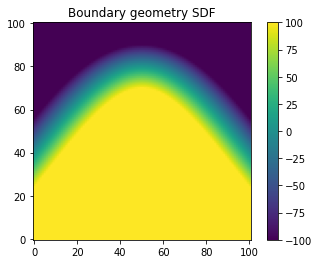

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the diagonal 2D sdf
sdf = read_sdf('sinusoid_new', 2)

# Load the staggered sdfs
sdf_x = read_sdf('sinusoid_new_x', 2)
sdf_y = read_sdf('sinusoid_new_y', 2)

# Flip interior/exterior (think this is a valid way to do it)
# sdf.data[:] = -sdf.data[:]
# sdf_x.data[:] = -sdf_x.data[:]
# sdf_y.data[:] = -sdf_y.data[:]

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry
import sympy as sp

x, y = sdf.grid.dimensions
h_x = x.spacing
h_y = y.spacing
zero = sp.core.numbers.Zero()
# cutoff = {(h_x/2, zero): 0., (zero, h_y/2, zero): 0.}
cutoff = {(zero, zero): 1.}
# cutoff = {(zero, zero): 0.75}

bg = BoundaryGeometry((sdf, sdf_x, sdf_y), cutoff=cutoff)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


In [3]:
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o,
                    time_order=1, staggered=dv.NODE)
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=s_o,
                          time_order=1)

In [4]:
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),  # Zero pressure on free surface
           dv.Eq(p.dx2 + p.dy2, 0),  # Zero laplacian
           dv.Eq(p.dx4 + 2*p.dx2dy2 + p.dy4, 0),  # Zero biharmonic
           dv.Eq(v[0].dx + v[1].dy, 0),  # Divergence of velocity equals zero
           dv.Eq(v[0].dx3 + v[1].dx2dy
                 + v[0].dxdy2 + v[1].dy3, 0)]  # Laplacian of divergence is zero

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

In [6]:
x, y = grid.dimensions

pdx = p.dx(x0=x+x.spacing/2)
pdy = p.dy(x0=y+y.spacing/2)
vxdx = v[0].forward.dx(x0=x)
vydy = v[1].forward.dy(x0=y)

derivs = (pdx, pdy, vxdx, vydy)

subs = boundary.substitutions(derivs)

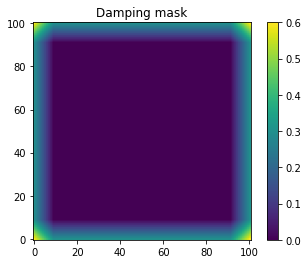

In [7]:
import numpy as np

damp = dv.Function(name='damp', grid=grid)

# Number of boundary layers
nbl = 10
taper = np.linspace(0, 0.3, nbl)

# Add the taper to the function's data
damp.data[:10] += taper[::-1, np.newaxis]
damp.data[-10:] += taper[:, np.newaxis]
damp.data[:, :10] += taper[np.newaxis, ::-1]
damp.data[:, -10:] += taper[np.newaxis, :]

plt.imshow(damp.data.T, origin='lower')
plt.title("Damping mask")
plt.colorbar()
plt.show()

In [8]:
from examples.seismic import TimeAxis, RickerSource

c = 1

t0 = 0.  # Simulation starts a t=0
tn = 600.  # Simulation last 0.55 seconds (550 ms)
dt = 0.5*10/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 500.

In [9]:
rho = 1
# Pressure update
eq_p = dv.Eq(p.forward, (1-damp)*(p + dt*rho*c**2*(subs[vxdx] + subs[vydy])))
# Velocity updates
eq_vx = dv.Eq(v[0].forward, v[0] + dt*subs[pdx]/rho)
eq_vy = dv.Eq(v[1].forward, v[1] + dt*subs[pdy]/rho)

In [10]:
src_term = src.inject(field=p.forward, expr=c*src*dt**2)

In [11]:
op = dv.Operator([eq_vx, eq_vy, eq_p] + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.62 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.6118709999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=8.799999999999988e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

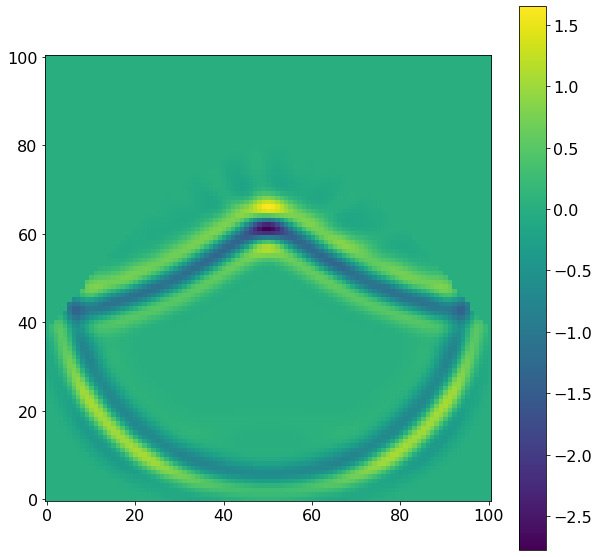

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(p.data[1].T, origin='lower')
plt.colorbar()
plt.show()

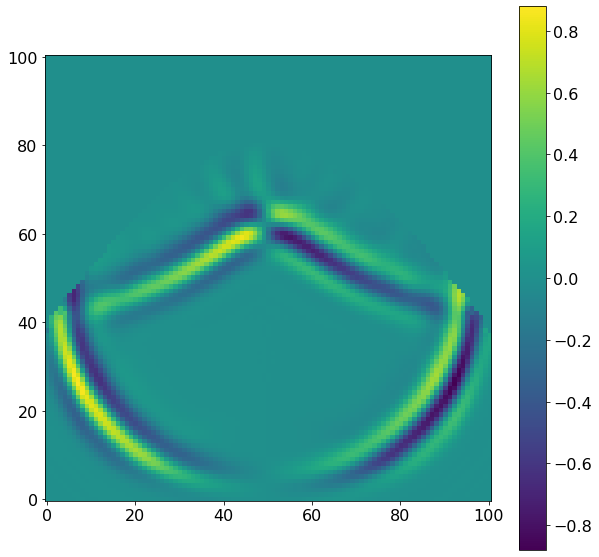

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(v[0].data[1].T, origin='lower')
plt.colorbar()
plt.show()

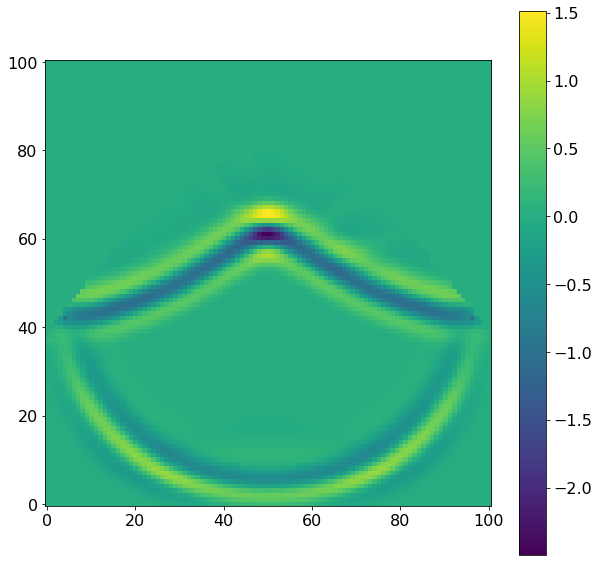

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(v[1].data[1].T, origin='lower')
plt.colorbar()
plt.show()

In [15]:
# FIXME: Need to update to the same sinusoid as the other test
# FIXME: This one looks different cos it just uses what was to hand
# FIXME: Need to fix the rippling -> weight scaling wrt distance?

# TODO: Check dense pos for the geometry -> maybe some weirdness there?
# Could be that boundary points get too bunched up?
# Is there some sort of gotcha on the geometry when curvature gets too large?

In [16]:
# Might want to overlay the sdf with the wavefield